Loading data from ASTR19_F25_group_project_data.txt...
Successfully loaded 82 data points.


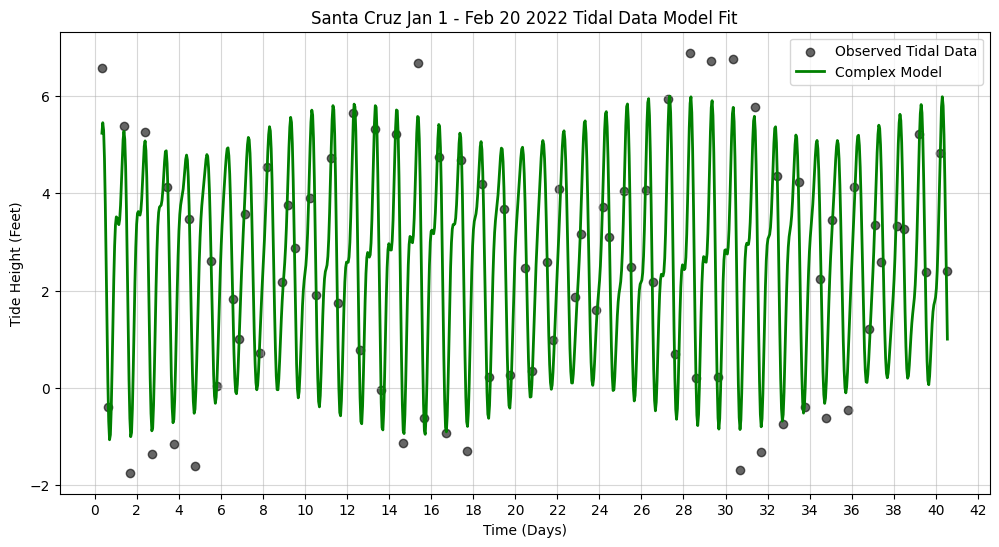


--- PART 3 STATISTICS ---
Intrinsic Scatter (Sigma): 0.638 ft
Experimental Error:        0.250 ft
Results show scatter in the data is larger than assumed experimental error


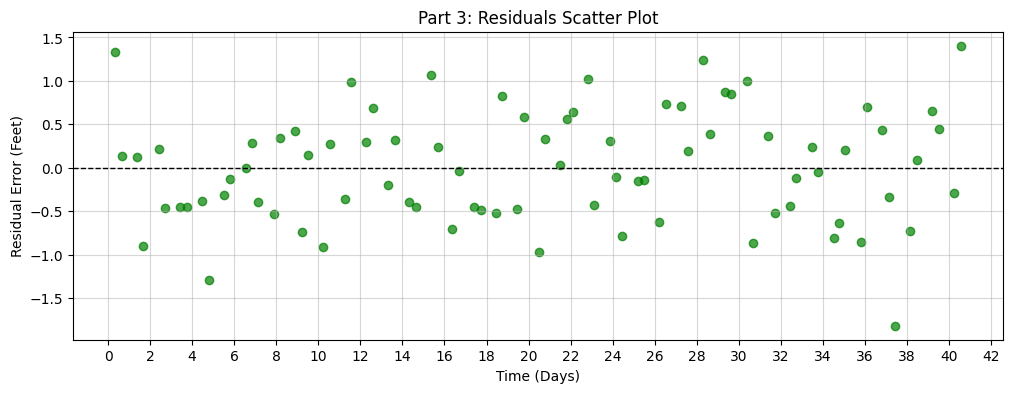

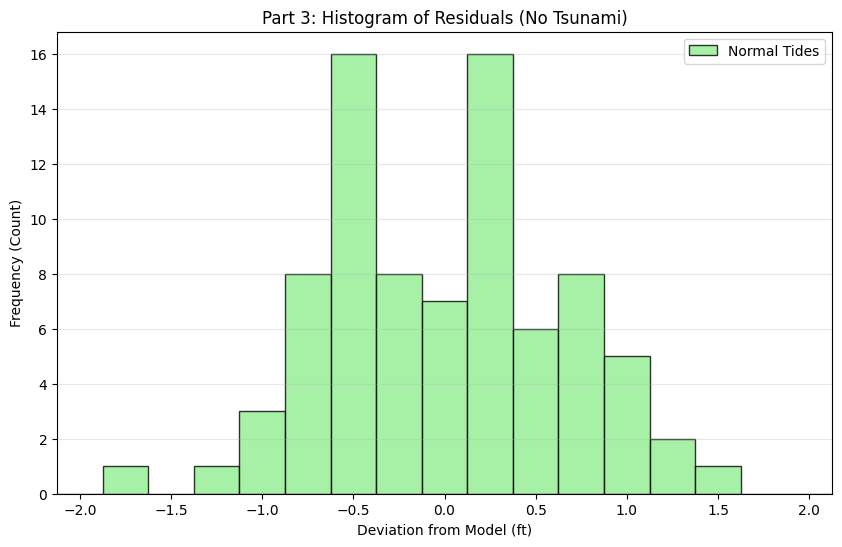


--- PART 4 TSUNAMI ANALYSIS ---
Tsunami Deviation:      2.0 ft
Significance (Z-Score): 3.14 sigma


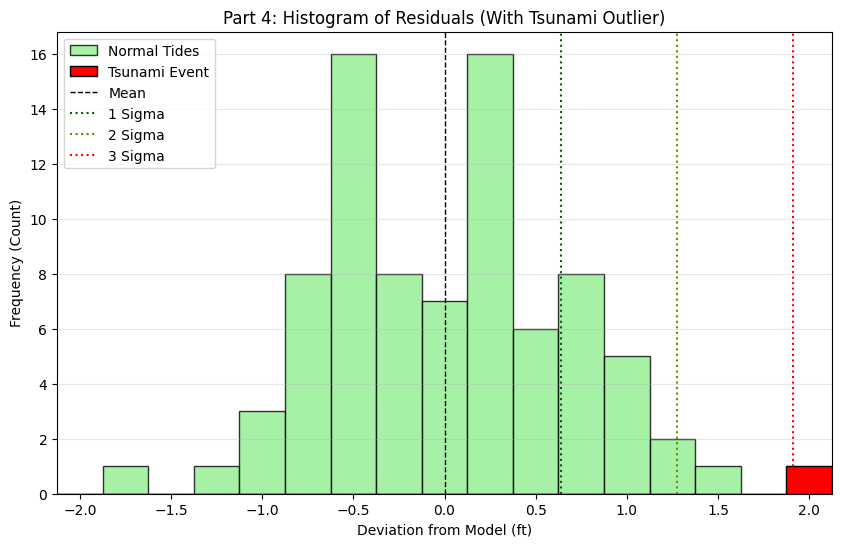

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

# ==========================================
# PART 1: LOAD AND CLEAN DATA
# ==========================================
filename = 'ASTR19_F25_group_project_data.txt'
times_in_days = []
tide_heights = []

print(f"Loading data from {filename}...")

try:
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'): continue
            
            cols = line.split()
            if len(cols) != 3: continue
            
            try:
                day = float(cols[0])
                time_str = cols[1]
                height = float(cols[2])
                
                hours, minutes = map(float, time_str.split(':'))
                t_day = (day - 1) + (hours / 24.0) + (minutes / 1440.0)
                
                times_in_days.append(t_day)
                tide_heights.append(height)
            except ValueError:
                continue
except FileNotFoundError:
    print("Error: File not found.")

times = np.array(times_in_days)
heights = np.array(tide_heights)
print(f"Successfully loaded {len(times)} data points.")


# ==========================================
# PART 2: THE COMPLEX MODEL & CURVE FIT
# ==========================================
def complex_model(t, A1, w1, p1, A2, w2, p2, A3, w3, p3, C):
    # Wave 1: Principal Lunar (M2) ~ 12.42h
    wave1 = A1 * np.sin(w1 * t + p1)
    # Wave 2: Principal Solar (S2) ~ 12.00h (Creates Spring/Neap beat)
    wave2 = A2 * np.sin(w2 * t + p2)
    # Wave 3: Diurnal (K1/O1) ~ 24h
    wave3 = A3 * np.sin(w3 * t + p3)
    return wave1 + wave2 + wave3 + C

# Initial Guesses
p0_complex = [
    2.5, 2*np.pi/0.5175, 0,  # M2
    1.0, 2*np.pi/0.5000, 0,  # S2
    2.0, 2*np.pi/1.0,    0,  # Diurnal
    2.0                      # Offset
]

# Fit Model
params, covariance = curve_fit(complex_model, times, heights, p0=p0_complex, sigma=np.full(len(heights), 0.25))

# Plot 1: Model Fit
smooth_time = np.linspace(times.min(), times.max(), 1000)
fit_curve = complex_model(smooth_time, *params)

plt.figure(figsize=(12, 6))
plt.scatter(times, heights, label='Observed Tidal Data', color='black', alpha=0.6)
plt.plot(smooth_time, fit_curve, label='Complex Model', color='green', linewidth=2)
plt.title("Santa Cruz Jan 1 - Feb 20 2022 Tidal Data Model Fit")
plt.xlabel("Time (Days)")
plt.ylabel("Tide Height (Feet)")
plt.legend()

# Grid ticks every 2 days
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.grid(True, which='both', alpha=0.5)

plt.savefig("complex_model_fit.pdf")
plt.show()


# ==========================================
# PART 3: RESIDUALS PLOT & HISTOGRAM
# ==========================================
model_at_points = complex_model(times, *params)
residuals = heights - model_at_points
sigma_residuals = np.std(residuals)
assumed_error = 0.25

print("\n--- PART 3 STATISTICS ---")
print(f"Intrinsic Scatter (Sigma): {sigma_residuals:.3f} ft")
print(f"Experimental Error:        {assumed_error:.3f} ft")

if sigma_residuals > assumed_error:
    print("Results show scatter in the data is larger than assumed experimental error")
else:
    print("Result: Scatter is consistent with noise.")

# Plot 2: Residuals Scatter
plt.figure(figsize=(12, 4))
plt.scatter(times, residuals, color='green', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Part 3: Residuals Scatter Plot")
plt.xlabel("Time (Days)")
plt.ylabel("Residual Error (Feet)")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.grid(True, which='both', alpha=0.5)
plt.savefig("complex_model_residuals.pdf")
plt.show()

# --- NEW: HISTOGRAM 1 (Residuals Only) ---
bin_width = 0.25
# Calculate tight bins for just the residuals
max_dist_normal = max(abs(residuals.min()), abs(residuals.max()))
limit_normal = (np.ceil(max_dist_normal / bin_width) * bin_width) + (bin_width / 2)
bins_normal = np.arange(-limit_normal, limit_normal + 0.001, bin_width)

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=bins_normal, color='lightgreen', edgecolor='black', alpha=0.8, label='Normal Tides')

plt.title("Part 3: Histogram of Residuals (No Tsunami)")
plt.xlabel("Deviation from Model (ft)")
plt.ylabel("Frequency (Count)")
plt.xlim(bins_normal[0], bins_normal[-1]) # Tight layout
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig("histogram_residuals_only.pdf")
plt.show()


# ==========================================
# PART 4: TSUNAMI SIGNIFICANCE & SECOND HISTOGRAM
# ==========================================
tsunami_deviation = 2.0 
z_score = (tsunami_deviation - np.mean(residuals)) / sigma_residuals

print("\n--- PART 4 TSUNAMI ANALYSIS ---")
print(f"Tsunami Deviation:      {tsunami_deviation} ft")
print(f"Significance (Z-Score): {z_score:.2f} sigma")

# --- HISTOGRAM 2 (With Tsunami) ---
# Recalculate bins to include the outlier
max_dist_tsunami = max(abs(residuals.min()), abs(residuals.max()), abs(tsunami_deviation))
limit_tsunami = (np.ceil(max_dist_tsunami / bin_width) * bin_width) + (bin_width / 2)
bins_tsunami = np.arange(-limit_tsunami, limit_tsunami + 0.001, bin_width)

plt.figure(figsize=(10, 6))

# Plot Normal Residuals
plt.hist(residuals, bins=bins_tsunami, color='lightgreen', edgecolor='black', alpha=0.8, label='Normal Tides')
# Plot Tsunami Outlier
plt.hist([tsunami_deviation], bins=bins_tsunami, color='red', edgecolor='black', label='Tsunami Event')

# Statistical Lines
mean_val = np.mean(residuals)
plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean_val + 1*sigma_residuals, color='darkgreen', linestyle=':', label='1 Sigma')
plt.axvline(mean_val + 2*sigma_residuals, color='olive', linestyle=':', label='2 Sigma')
plt.axvline(mean_val + 3*sigma_residuals, color='red', linestyle=':', label='3 Sigma')

plt.title("Part 4: Histogram of Residuals (With Tsunami Outlier)")
plt.xlabel("Deviation from Model (ft)")
plt.ylabel("Frequency (Count)")
plt.xlim(bins_tsunami[0], bins_tsunami[-1]) # Tight layout
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig("histogram_residuals_tsunami.pdf")
plt.show()